# Create flying node graph
This Notebook will create the graph we will use for flying our drone. We do it once so we don't have to do it everytime we load the simulator.

## Imports

In [1]:
import numpy as np
from skimage.morphology import medial_axis
from skimage.util import invert
from planning_utils import create_grid
import time

%matplotlib inline

## Load Data

In [2]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


## Visualize map grid

In [3]:
print('start')
drone_altitude = 5
safety_distance = 3
grid, _, north_offset, east_offset = create_grid(data, drone_altitude, safety_distance)
print('done')

start
done


start


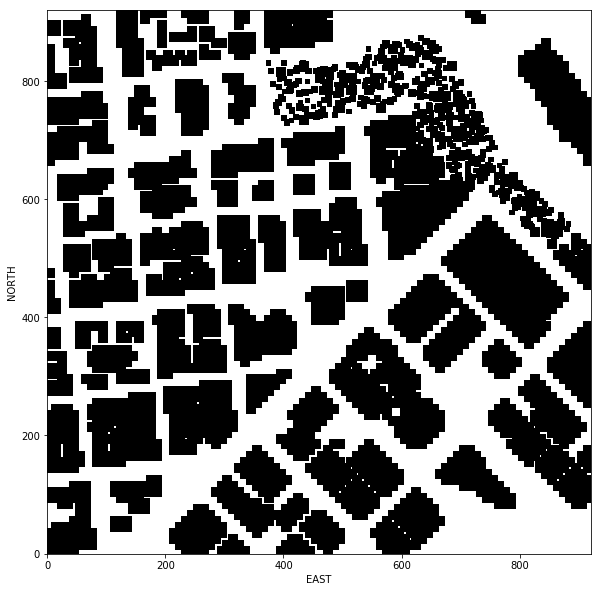

done


In [4]:
import matplotlib.pyplot as plt
print('start')
# Plot it up!
fig = plt.figure(figsize=(10,10))
plt.imshow(grid, origin='lower', cmap='Greys')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()
print('done')

## Medial Axis graph method

In [5]:
print('Creating Medial Axis')
# Create a voronoi graph based on location of obstacle centres (2D no height)
t0 = time.time()
skeleton = medial_axis(invert(grid))
print('Medial Axis with {0} nodes'.format(skeleton.shape))
print('Medial Axis took {0} seconds to build'.format(time.time()-t0))

Creating Medial Axis
Medial Axis with (921, 921) nodes
Medial Axis took 0.31870150566101074 seconds to build


## Save to pickle

In [6]:
import pickle

# Dump the graph with Pickle
pkl_filename = 'graph.medialaxis.p'

try:
    with open(pkl_filename, 'wb+') as pfile:
        print('Saving to pickle file ', pkl_filename)
        pickle.dump(
        {
            'skeleton': skeleton,
        },
        pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to ', pkl_filename, ':', e)

print('done')

Saving to pickle file  graph.medialaxis.p
done


## Load from pickle

In [7]:
import pickle

pkl_filename = 'graph.medialaxis.p'
with open(pkl_filename, "rb") as pfile:
    print('Reading pickle')
    dist_pickle = pickle.load(pfile)

    skeleton = dist_pickle['skeleton']

print('done')

Reading pickle
done


## Visualize graph

start


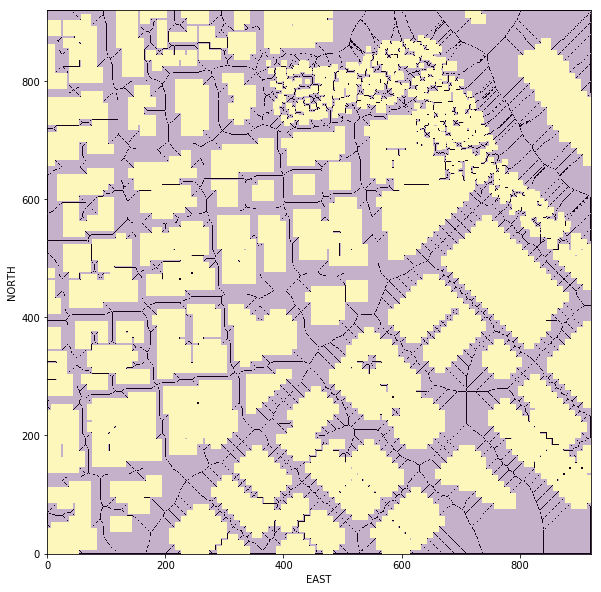

done


In [8]:
import matplotlib.pyplot as plt
print('start')
fig = plt.figure(figsize=(10,10))
plt.imshow(grid, origin='lower')
plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()
print('done')

## A*

In [9]:
def find_random_node(skel, node):
    skel_cells = np.transpose(skel.nonzero())
    node_min_dist = np.linalg.norm(np.array(node) - np.array(skel_cells), axis=1).argmin()
    near_node = skel_cells[node_min_dist]

    return near_node

In [16]:
start_ne = np.random.choice(len(skeleton),2)
goal_ne = np.random.choice(len(skeleton),2)

skel_start = find_random_node(skeleton, start_ne)
skel_goal = find_random_node(skeleton, goal_ne)

print('Start location: {0}, Start Node: {1}'.format(start_ne, skel_start))
print('Goal location: {0}, Goal Node: {1}'.format(goal_ne, skel_goal))

Start location: [290 482], Start Node: [286 486]
Goal location: [620 387], Goal Node: [620 400]


In [17]:
from planning_utils import a_star, heuristic

# Run A* on the skeleton
path, cost = a_star(invert(skeleton).astype(np.int), heuristic, tuple(skel_start), tuple(skel_goal))
print("Path length = {0}, path cost = {1}".format(len(path), cost))
#print(path)

Path length = 354, path cost = 422.17366491630787


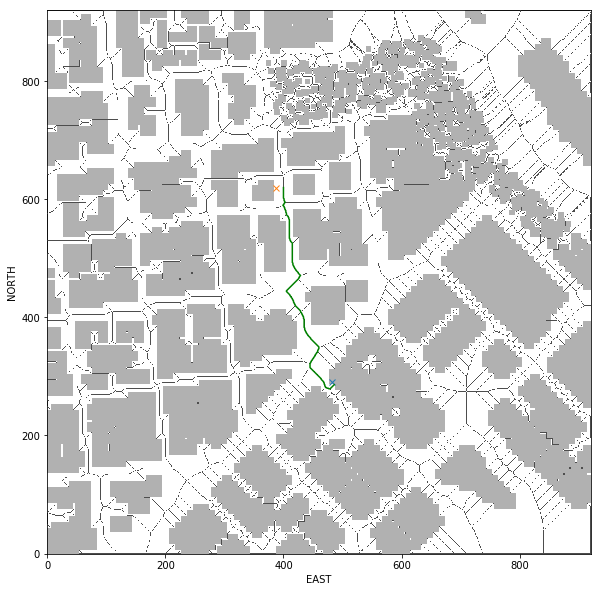

In [18]:
fig = plt.figure(figsize=(10,10))
plt.imshow(grid, cmap='Greys', origin='lower')
plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)
# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

pp = np.array(path)
plt.plot(pp[:, 1], pp[:, 0], 'g')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()